In [472]:
from typing import Callable, Iterator, Sequence
from tqdm import tqdm
from functools import partial

import os
import numpy as np
import matplotlib.pylab as plt

import jax.numpy as jnp
import jax
import flax.linen as nn
import optax
import haiku as hk
import chex

## Dataset loading

In [473]:
data_dir = 'dataset'
X_train = np.load(os.path.join(data_dir, 'X_train_checkerboard.npy'))
X_test = np.load(os.path.join(data_dir, 'X_test_checkerboard.npy'))

## Define MLP score function

In [474]:
latent_dim = 300

class Discriminator(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x: jax.Array, train: bool) -> jax.Array:
        for f in self.features[:-1]:
            x = nn.Dense(f)(x)
            x = nn.leaky_relu(x, negative_slope=0.2)
            x = nn.Dropout(rate=0.1, deterministic=not train)(x)
        x = nn.Dense(self.features[-1])(x)
        x = nn.sigmoid(x)
        return x
    
discriminator = Discriminator(features=[512, 128, 1])
print(discriminator.tabulate(jax.random.PRNGKey(0), np.zeros((1, 2)), False))


                             Discriminator Summary                              
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path      ┃ module        ┃ inputs         ┃ outputs        ┃ params         ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│           │ Discriminator │ - float32[1,2] │ float32[1,1]   │                │
│           │               │ - False        │                │                │
├───────────┼───────────────┼────────────────┼────────────────┼────────────────┤
│ Dense_0   │ Dense         │ float32[1,2]   │ float32[1,512] │ bias:          │
│           │               │                │                │ float32[512]   │
│           │               │                │                │ kernel:        │
│           │               │                │                │ float32[2,512] │
│           │               │                │                │                │
│           │              

In [475]:
class Generator(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, z: jax.Array, train: bool) -> jax.Array:
        for f in self.features[:-1]:
            z = nn.Dense(f)(z)
            z = nn.BatchNorm(use_running_average=not train)(z)
            z = nn.relu(z)
        x = nn.Dense(self.features[-1])(z)
        return x
    
generator = Generator(features=[128, 512, 2])
print(generator.tabulate(jax.random.PRNGKey(0), np.zeros((1, 2)), False))


                               Generator Summary                                
┏━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ path       ┃ module    ┃ inputs      ┃ outputs    ┃ batch_stats ┃ params     ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│            │ Generator │ -           │ float32[1… │             │            │
│            │           │ float32[1,… │            │             │            │
│            │           │ - False     │            │             │            │
├────────────┼───────────┼─────────────┼────────────┼─────────────┼────────────┤
│ Dense_0    │ Dense     │ float32[1,… │ float32[1… │             │ bias:      │
│            │           │             │            │             │ float32[1… │
│            │           │             │            │             │ kernel:    │
│            │           │             │            │             │ float32[2… │
│            │           │ 

## Define the denoising score matching loss

In [476]:
@partial(jax.jit, static_argnames=['train'])
def gan_loss(d_params:chex.ArrayTree, g_params:chex.ArrayTree, batch: jax.Array, key: chex.PRNGKey, train: bool):
    # Generate sample
    key, z_key = jax.random.split(key)
    z_batch = jax.random.normal(z_key, (batch.shape[0], latent_dim))
    fake_batch, variables = generator.apply(g_params, z_batch, train=train, mutable=['batch_stats'])

    # Apply discriminator
    key1, key2 = jax.random.split(key)
    real_preds = discriminator.apply(d_params, batch, train=train, rngs={'dropout': key1})
    fake_preds = discriminator.apply(d_params, fake_batch, train=train, rngs={'dropout': key2})

    # Compute loss
    d_loss = -jnp.mean(jnp.log(real_preds) + jnp.log(1 - fake_preds))
    # g_loss = jnp.mean(jnp.log(1 - fake_preds))
    g_loss = -jnp.mean(jnp.log(fake_preds))

    return d_loss, g_loss

## Train the model

In [477]:
d_optimizer = optax.adam(learning_rate=5e-5)
g_optimizer = optax.adam(learning_rate=5e-5)
prng_seq = hk.PRNGSequence(jax.random.PRNGKey(0))

@jax.jit
def do_batch_update(batch, d_params, g_params, opt_d_state, opt_g_state, key):
    # Train discriminator
    k = 1
    for _ in range(k):
        key, z_key = jax.random.split(key)
        compute_d_loss = lambda d_params: gan_loss(d_params, g_params, batch, z_key, train=True)[0]
        d_grad = jax.grad(compute_d_loss)(d_params)
        d_updates, opt_d_state = d_optimizer.update(d_grad, opt_d_state)
        d_params = optax.apply_updates(d_params, d_updates)

    # Train generator
    compute_g_loss = lambda g_params: gan_loss(d_params, g_params, batch, key, train=True)[1]
    g_grad = jax.grad(compute_g_loss)(g_params)
    g_updates, opt_g_state = g_optimizer.update(g_grad, opt_g_state)
    g_params = optax.apply_updates(g_params, g_updates)

    return d_params, g_params, opt_d_state, opt_g_state

In [478]:
class BatchManager(Iterator[np.ndarray]):
    
    def __init__(
        self,
        data: np.ndarray,
        batch_size: int,
        key: chex.PRNGKey
    ):
        batch_size = min(batch_size, len(data))
        self._num_batches = len(data) // batch_size
        self._batch_idx = None
        self._batch_size = batch_size
        self._key = hk.PRNGSequence(key)
        self._data = data
        self._reset()

    @property
    def num_batches(self) -> int:
        return self._num_batches

    def _reset(self) -> None:
        self._perm = np.array(jax.random.permutation(next(self._key), np.arange(len(self._data))))
        self._batch_idx = 0

    def __next__(self) -> np.ndarray:
        assert self._batch_idx is not None
        assert self._batch_idx >= 0 and self._batch_idx < self._num_batches
        inds = self._perm[self._batch_idx * self._batch_size : (self._batch_idx + 1) * self._batch_size]
        batch = self._data[inds]
        self._batch_idx += 1
        if self._batch_idx >= self._num_batches:
            self._reset()
        return batch

In [479]:
# Parameters
num_epochs = 10000
batch_size = 32
bm = BatchManager(X_train, batch_size, key=next(prng_seq))

# Initialize Generator and Discriminator
g_params = generator.init(next(prng_seq), jax.random.normal(next(prng_seq), (1, latent_dim)), train=False)
d_params = discriminator.init(next(prng_seq), X_train[:1, ...], train=False)

opt_g_state = g_optimizer.init(g_params)
opt_d_state = d_optimizer.init(d_params)

# Training Loop
d_train_losses = []
g_train_losses = []
d_test_losses = []
g_test_losses = []
for epoch in tqdm(range(num_epochs), "Epoch"):
    for _ in range(bm.num_batches):
        batch = next(bm)
        d_params, g_params, opt_d_state, opt_g_state = do_batch_update(
            batch, d_params, g_params, opt_d_state, opt_g_state, next(prng_seq))

    # Compute losses
    d_train_loss, g_train_loss = gan_loss(d_params, g_params, X_train, next(prng_seq), train=False)
    d_test_loss, g_test_loss = gan_loss(d_params, g_params, X_test, next(prng_seq), train=False)
    d_train_losses.append(d_train_loss)
    g_train_losses.append(g_train_loss)
    d_test_losses.append(d_test_loss)
    g_test_losses.append(g_test_loss)

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 100%|██████████| 10000/10000 [10:05<00:00, 16.52it/s]


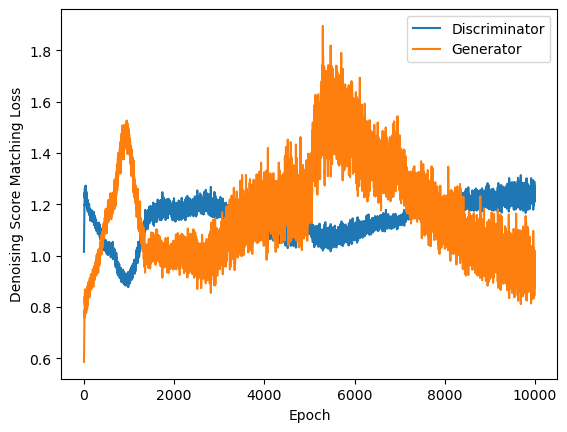

In [480]:
# Apply moving average filer to losses
window_size = 100
window = np.ones(window_size) / window_size
train_losses_f = np.convolve(d_train_losses, window, mode='valid')
test_losses_f = np.convolve(g_train_losses, window, mode='valid')

# Plot original losses
plt.plot(d_train_losses, label='Discriminator')
plt.plot(g_train_losses, label='Generator')

# Calculate the correct x positions for the smoothed losses
x_train_f = np.arange(window_size // 2, window_size // 2 + train_losses_f.shape[0])
x_test_f = np.arange(window_size // 2, window_size // 2 + test_losses_f.shape[0])

# Plot smoothed losses
# plt.plot(x_train_f, train_losses_f, label='Smoothed Train Losses')
# plt.plot(x_test_f, test_losses_f, label='Smoothed Test Losses')

# Adding labels and title
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Denoising Score Matching Loss')  # Label for the y-axis

plt.legend()
plt.show()

## Sample from the model

In [481]:
# Function to generate samples from the generator
def generate_samples(g_params: chex.ArrayTree, key: chex.PRNGKey, num_samples:int):
    z = jax.random.normal(key, (num_samples, latent_dim))
    samples = generator.apply(g_params, z, train=False)
    return samples

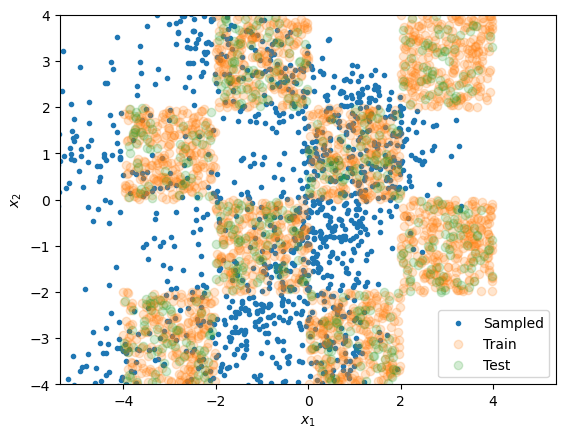

In [482]:
# Generate samples
samples = generate_samples(g_params, next(prng_seq), 2000)

# Plot samples
plt.scatter(samples[:, 0], samples[:, 1], marker='.', label='Sampled')
plt.scatter(X_train[:, 0], X_train[:, 1], alpha=0.2, marker='o', label='Train')
plt.scatter(X_test[:, 0], X_test[:, 1], alpha=0.2, marker='o', label='Test')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.axis('equal')
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.legend()
plt.show() 